In [1]:
import numpy as np
import pathlib as pa
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.model_selection as ms
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

#Model
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import matplotlib.pyplot as plt


In [2]:
BASE_DIR = pa.Path(os.path.abspath('')).parent
DATA_DIR = BASE_DIR.joinpath('data')
WORK_DIR = BASE_DIR.joinpath('Model')

In [3]:
# read in data
all_data_csv = list(DATA_DIR.glob('**/*.csv'))
all_data_csv = [str(path) for path in all_data_csv]

all_data_txt = list(DATA_DIR.glob('**/*.txt'))
all_data_txt = [str(path) for path in all_data_txt]

BASE_DATA =pd.read_csv(all_data_csv[0])
# BASE_DATA =pd.read_csv(all_data_csv[1])

# price_histroy = pd.read_csv(all_data_txt[0])

full_name = list(BASE_DATA.keys())

In [4]:
list(BASE_DATA.columns)

['campaign_id',
 'campaign_announcement_date',
 'campaign_title',
 'campaign_objective_primary',
 'value_demand',
 'governance_demand',
 'activist_campaign_tactic',
 'total_number_of_board_seats',
 'number_of_board_seats_sought',
 'short_or_majority_or_full_slate',
 'proxy_proposal',
 'glass_lewis_support',
 'iss_support',
 'activist_id',
 'activist_name',
 'activist_group',
 'first_trade_date',
 'last_trade_date',
 'ownership_pecent_on_announcement',
 'company_id',
 'company_name',
 'sector',
 'price_at_announcement',
 'ltm_eps_at_announcement',
 'earnings_yield_at_announcement',
 'current_entity_status',
 'current_entity_detail',
 'public_before_or_after_campaign_announcement',
 'poison_pill_in_force_prior_to_announcement',
 'poison_pill_adopted_in_response_to_campaign',
 'pre_18m_announcement_date',
 'pre_12m_announcement_date',
 'pre_6m_announcement_date',
 'pre_3m_announcement_date',
 'pre_18m_stock_price',
 'pre_12m_stock_price',
 'pre_6m_stock_price',
 'pre_3m_stock_price',
 'pr

In [5]:
BASE_DATA.shape

(9571, 119)

In [6]:
# Get rid of extreme value of ltm_eps_at_announcement
eps_col = BASE_DATA.columns == 'ltm_eps_at_announcement'
eps = BASE_DATA.loc[:,eps_col]
low = .05
high = .95
quant_df = eps.quantile([low, high])
eps = eps.apply(lambda x: x[(x.dtypes == 'float64') & (x>= quant_df.loc[low,x.name]) & (x <= quant_df.loc[high,x.name]) | (x.isnull())], axis=0)
BASE_DATA = pd.concat([BASE_DATA.loc[:,~eps_col], eps], join = 'inner',axis=1)
# Shape after deleting extreme value of ltm_eps_at_announcement
BASE_DATA.shape

(8723, 119)

## Proxy result
    Assume all the information in X is available before announncement
    


In [7]:
# Hand picked X variables that do not leak information
X = ['campaign_objective_primary','value_demand','governance_demand','proxy_proposal',\
     'number_of_board_seats_sought','sector','total_number_of_board_seats',\
     'glass_lewis_support','iss_support','ownership_pecent_on_announcement','price_at_announcement',\
     'ltm_eps_at_announcement','earnings_yield_at_announcement','current_entity_detail','current_entity_status',\
     'public_before_or_after_campaign_announcement','poison_pill_in_force_prior_to_announcement',\
     'pre_18m_price_to_earnings','pre_12m_price_to_earnings',
     'pre_6m_price_to_earnings','pre_3m_price_to_earnings',
     'pre_18m_total_return','pre_12m_total_return',
     'pre_6m_total_return','pre_3m_total_return',
     'used_call_special_meeting_tactic',
     'used_hostile_offer_tactic',
     'used_lawsuit_tactic',
     'used_letter_to_stockholders_tactic',
     'used_no_or_unknown_tactic',
     'used_nominate_slate_of_directors_tactic',
     'used_propose_binding_proposal_tactic',
     'used_propose_precatory_proposal_tactic',
     'used_proxy_access_nomination_tactic',
     'used_publicly_disclosed_letter_to_board_or_management_tactic',
     'used_take_action_by_written_consent_tactic',
     'used_tender_offer_launched_tactic',
     'used_tender_offer_stake_only_tactic',
     'used_threaten_proxy_fight_tactic',
     'used_unsolicited_offer_tactic', 
     'used_withhold_vote_for_directors_tactic'
    ]

# Y1 as grouped proxy_campaign_winner_or_result 
Y = ['proxy_result']
# Y2 as board seat ratio = number of board seats gained / number of board seats sought
Y2 = ['number_of_board_seats_sought', 'number_of_board_seats_gained']

# Adjust data type
BASE_DATA['number_of_board_seats_sought'] = BASE_DATA['number_of_board_seats_sought'].astype('object')
BASE_DATA['total_number_of_board_seats'] = BASE_DATA['total_number_of_board_seats'].astype('object')

# Get whether variable is categorical
cate = BASE_DATA[X].dtypes == object
cate_name = BASE_DATA[X].select_dtypes(include=['object']).columns
num_name = BASE_DATA[X].select_dtypes(exclude=['object']).columns


# Fill missing proxy_campaign_winner_or_result as Missing
BASE_DATA['proxy_campaign_winner_or_result'] = BASE_DATA['proxy_campaign_winner_or_result'].fillna('Missing')

# Show proxy_campaign_winner_or_result composition
print('Original proxy_campaign_winner_or_result composition:\n', 
      BASE_DATA['proxy_campaign_winner_or_result'].value_counts())

# Group proxy_campaign_winner_or_result into three levels: Missing, Dissident, and Management
BASE_DATA['proxy_result'] = np.nan
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Missing'] = 'Missing'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Settled/Concessions Made'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Withdrawn'] = 'Management'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Dissident'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Split'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Management'] = 'Management'

# Drop any record with missing proxy_result, which are records with proxy_campaign_winner_or_result == Pending
df = BASE_DATA.dropna(how = 'any',subset=['proxy_result'])

# Show proxy_result composition after grouping
print('\nGrouped proxy_campaign_winner_or_result composition:\n', df['proxy_result'].value_counts())

Original proxy_campaign_winner_or_result composition:
 Missing                     6657
Settled/Concessions Made     673
Management                   513
Withdrawn                    446
Dissident                    337
Split                         55
Pending                       42
Name: proxy_campaign_winner_or_result, dtype: int64

Grouped proxy_campaign_winner_or_result composition:
 Missing       6657
Dissident     1065
Management     959
Name: proxy_result, dtype: int64


## Complete case analysis on proxy winner or results

In [8]:
df2 = df[df['proxy_result'] != 'Missing']

## Note:
We grouped proxy_campaign_winner_or_result into the following categories:
    - Missing
    - Dissident
        - Settled/Concessions Made
        - Dissident
        - Split (dissident's partial success, so also count as dissident)
    - Manamgent
        - Managment
        - Withdrawn
    - Delete Pending records

# Data preprocessing

### Utility

In [9]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

# def TPR_FPR(x_test,y_test,model,including_missing =True):
#     # Binarize multi-class lable for true and predicted y_test
#     if including_missing:
#         y_test_label = label_binarize(y_test, classes=['Missing', 'Dissident', 'Management'])
#         pred = model.predict(x_test)
#         pred_label = label_binarize(pred, classes=['Missing', 'Dissident', 'Management'])
#     else:
#         y_test_label = label_binarize(y_test, classes=['Dissident', 'Management'])
#         pred = model.predict(x_test)
#         pred_label = label_binarize(pred, classes=['Dissident', 'Management'])

    
#     # Calculate True positive and False positive rate
#     TP = lambda y_test,y_pred: np.sum(np.array([(y_test[i] == y_pred[i] and y_test[i] == 1) for i in range(len(y_test))]))
#     FN = lambda y_test,y_pred: np.sum(np.array([(y_test[i] != y_pred[i] and y_test[i] == 1) for i in range(len(y_test))]))
#     TN = lambda y_test,y_pred: np.sum(np.array([(y_test[i] == y_pred[i] and y_test[i] == 0) for i in range(len(y_test))]))
#     FP = lambda y_test,y_pred: np.sum(np.array([(y_test[i] != y_pred[i] and y_test[i] == 0) for i in range(len(y_test))]))

#     TPR = []
#     FPR = []
#     for i in range(pred_label.shape[1]):
#         TPR.append(TP(y_test_label[:,i],pred_label[:,i])/ (TP(y_test_label[:,i],pred_label[:,i]) + FN(y_test_label[:,i],pred_label[:,i])))
#         FPR.append(FP(y_test_label[:,i],pred_label[:,i])/ (FP(y_test_label[:,i],pred_label[:,i]) + TN(y_test_label[:,i],pred_label[:,i])))
        
        
#     # Display in dataframe form
#     if including_missing:
#         d1 = pd.DataFrame(TPR, index=['Missing', 'Dissident', 'Management'], columns = ['True Positive Rate'])
#         d2 = pd.DataFrame(FPR, index=['Missing', 'Dissident', 'Management'], columns = ['False Positive Rate'])
#     else:
#         confusion_matrix(y_test, pred_label)
#         d1 = pd.DataFrame(TPR, index=['Management'], columns = ['True Positive Rate'])
#         d2 = pd.DataFrame(FPR, index=['Management'], columns = ['False Positive Rate'])
#     return pd.concat([d1,d2], axis=1)

def produce_confusion_matrix(x_test,y_test,model):
    pred = model.predict(x_test)
    matrix = confusion_matrix(y_test, pred, labels=y_test['proxy_result'].unique())
    # By definition a confusion matrix C is such that Cij is equal to the number of observations 
    # known to be in group i but predicted to be in group j.
    # Thus in binary classification, the count of true negatives is C0,0, false negatives is C1,0, 
    # true positives is C1,1 and false positives is C0,1.
    precision = [matrix[i,i] / sum(matrix[:,i]) for i in range(matrix.shape[1])]
    recall = [matrix[i,i] / sum(matrix[i,:]) for i in range(matrix.shape[1])]
    d1 = pd.DataFrame(precision, columns=['Precision'], index = y_test['proxy_result'].unique())
    d2 = pd.DataFrame(recall, columns=['Recall'], index = y_test['proxy_result'].unique())
    precision_recall = pd.concat([d1,d2], axis=1)
    return matrix, precision_recall



## Preprocessing_Pipeline

### proxy_campaign_winner_or_result missing as a new category

In [10]:
# SMOTE
sm = SMOTENC(random_state=42, categorical_features=cate)

# Impute missing numerical variable as -9999
pipeline_component = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = -9999))

# Impute missing categorical variable as NA and do One-Hot Encoding
pipeline_component_cate = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'constant',
                                                      fill_value = 'NA'),
                                          (OneHotEncoder(handle_unknown='ignore')))

# Combine numerical and categorical variables preprocessing
preprocess = make_column_transformer((pipeline_component,~cate),
                                     (pipeline_component_cate,cate))

# Perform preprocessing on data with missing y
x_preprocessed = preprocess.fit(df[X],df[Y]).transform(df[X])

# Perform preprocessing on data without missing y
x_preprocessed_complete = preprocess.fit(df2[X],df2[Y]).transform(df2[X])

# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, df[Y], test_size = 0.2, random_state=0)
x_train_complete, x_test_complete, y_train_complete, y_test_complete = train_test_split(x_preprocessed_complete, 
                                                                                        df2[Y], test_size = 0.2, 
                                                                                        random_state=0)

# Print proxy_result composition before up-sampling
print('x_train, y_train shape before up-sampling:\n', x_train.shape, y_train.shape)
print('\nproxy_result composition before up-sampling:\n',y_train['proxy_result'].value_counts())

# Perform SMOTE up-sampling
x_train, y_train = sm.fit_resample(x_train, y_train)
x_train_complete, y_train_complete = sm.fit_resample(x_train_complete, y_train_complete)

# Print proxy_result composition after up-sampling
print('\nx_train, y_train shape after up-sampling:\n',x_train.shape, y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('\nproxy_result composition after up-sampling:\n', dict(zip(unique, counts)))
      

x_train, y_train shape before up-sampling:
 (6944, 208) (6944, 1)

proxy_result composition before up-sampling:
 Missing       5309
Dissident      876
Management     759
Name: proxy_result, dtype: int64

x_train, y_train shape after up-sampling:
 (15927, 208) (15927,)

proxy_result composition after up-sampling:
 {'Dissident': 5309, 'Management': 5309, 'Missing': 5309}


## l1 penalty logistic regression

In [11]:
# Logistic regression with l1 norm
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# Perform grid search
param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
grid = GridSearchCV(lg_l1, param_grid, cv=2)
grid.fit(x_train, y_train)
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'C': 2.0}
Training accuracy for Logistic Regression is 0.81108
Testing accuracy for Logistic Regression is 0.90616


In [12]:
# confusion_matrix with order: ['Missing', 'Dissident', 'Management']
conf, pre_recall = produce_confusion_matrix(x_test, y_test, grid) 
conf

array([[1337,    8,    3],
       [   6,  128,   55],
       [   1,   90,  109]])

In [13]:
pre_recall

,Precision,Recall
Missing,0.994792,0.991840
Dissident,0.566372,0.677249
Management,0.652695,0.545000


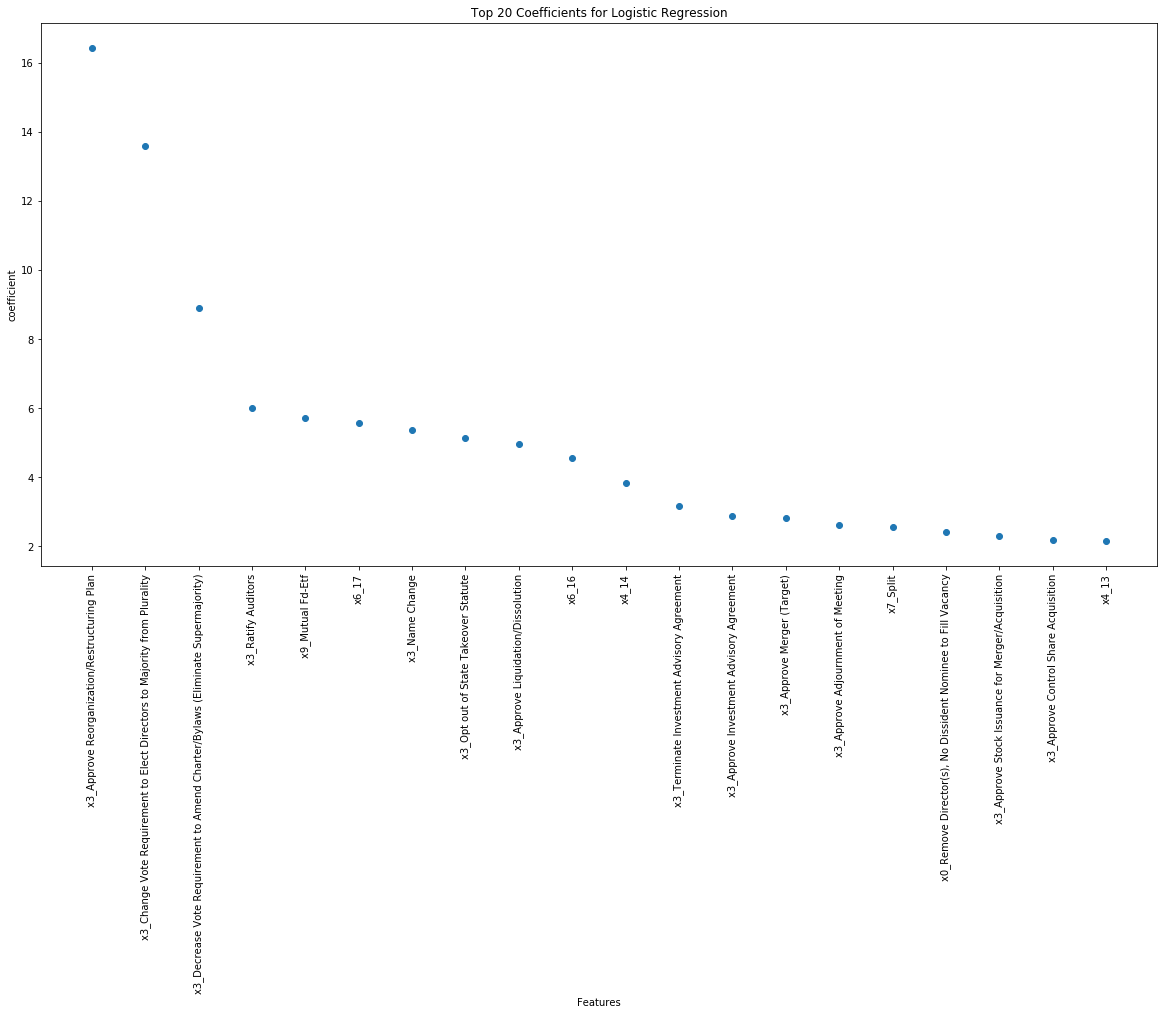

In [14]:
# Logistic regression with best parameter
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto', C = 2)
lg_l1.fit(x_train, y_train)

# Get feature name after one-hot encoding
hot = OneHotEncoder(handle_unknown='ignore')
hot.fit_transform(df[X].select_dtypes(include = 'object').replace(np.nan,'Missing'))
hot.get_feature_names()
combine = list(num_name) + hot.get_feature_names().tolist()

# Get top 20 important features
feature_importance_dict = dict(zip(combine, lg_l1.coef_[0]))
top_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]}
name = [item for item in top_20_important]
importance = [top_20_important[item] for item in top_20_important]

# Plot top 20 important features
_=plt.figure(figsize=(20,10))
_=plt.scatter(name,importance)
_=plt.xticks(rotation='vertical')
_=plt.title('Top 20 Coefficients for Logistic Regression')
_=plt.xlabel('Features')
_=plt.ylabel('coefficient')

## Complete case

In [15]:
# Logistic regression
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# Perform grid search
param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
grid = GridSearchCV(lg_l1, param_grid, cv=2)
grid.fit(x_train_complete, y_train_complete)
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train_complete, y_train_complete),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test_complete, y_test_complete),5)))

The best parameter for Logistic is {'C': 2.0}
Training accuracy for Logistic Regression is 0.67943
Testing accuracy for Logistic Regression is 0.5679


In [16]:
# confusion_matrix with order: ['Management', 'Dissident']
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, grid) 
conf

array([[ 97,  79],
       [ 96, 133]])

In [17]:
pre_recall

,Precision,Recall
Management,0.502591,0.551136
Dissident,0.627358,0.580786


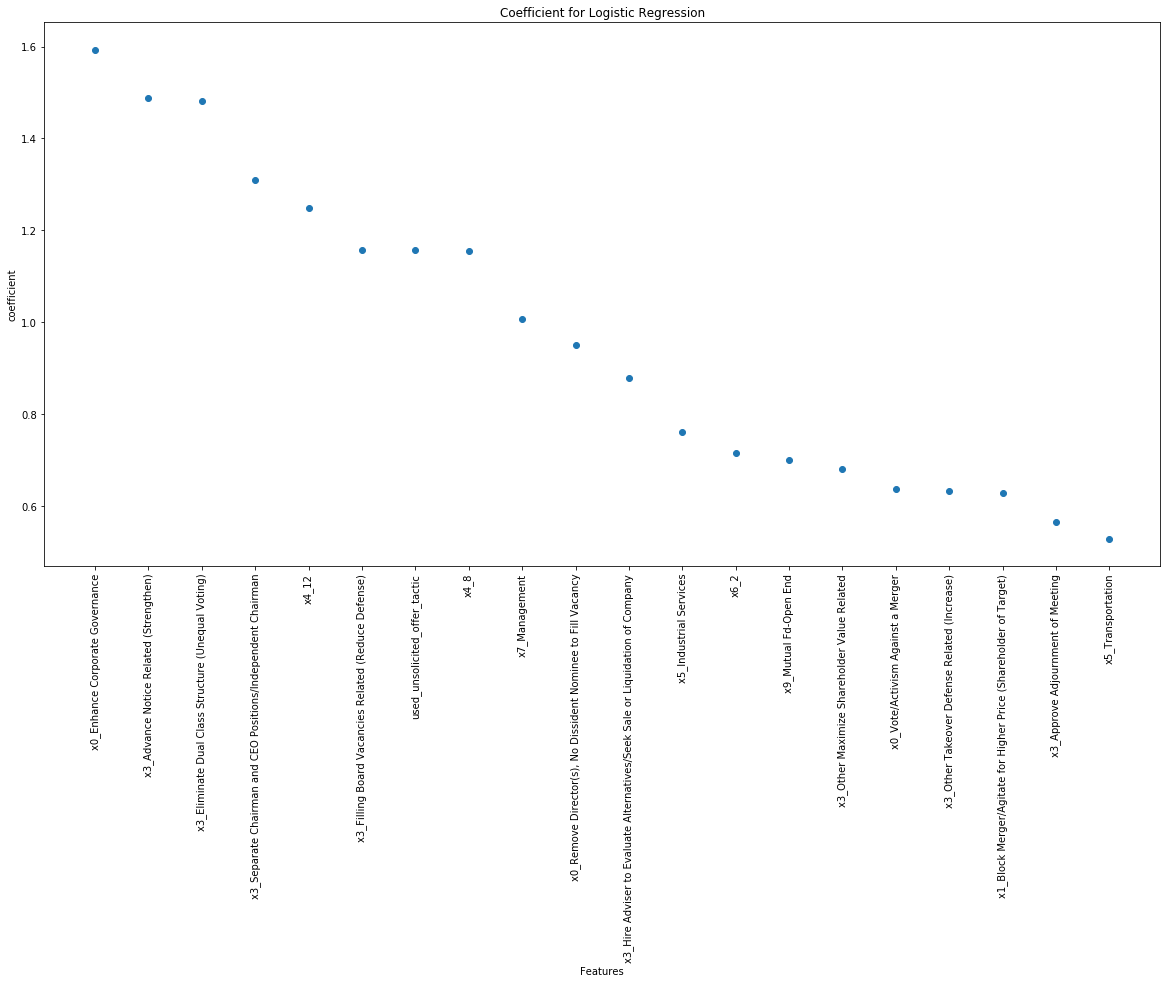

In [18]:
# Logistic regression with best parameter
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto', C = 2)
lg_l1.fit(x_train_complete, y_train_complete)

# Get feature name after one-hot encoding
hot = OneHotEncoder(handle_unknown='ignore')
hot.fit_transform(df2[X].select_dtypes(include = 'object').replace(np.nan,'Missing'))
hot.get_feature_names()
combine2 = list(num_name) + hot.get_feature_names().tolist()

# Get top 20 important features
feature_importance_dict = dict(zip(combine2, lg_l1.coef_[0]))
top_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]}
name = [item for item in top_20_important]
importance = [top_20_important[item] for item in top_20_important]

# Plot top 20 important features
_=plt.figure(figsize=(20,10))
_=plt.scatter(name,importance)
_=plt.xticks(rotation='vertical')
_=plt.title('Coefficient for Logistic Regression')
_=plt.xlabel('Features')
_=plt.ylabel('coefficient')

In [19]:
# Ordered feature importance
{k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)}

{'x0_Enhance Corporate Governance': 1.593049749619865,
 'x3_Advance Notice Related (Strengthen)': 1.488090650231002,
 'x3_Eliminate Dual Class Structure (Unequal Voting)': 1.4819996446126342,
 'x3_Separate Chairman and CEO Positions/Independent Chairman': 1.3092861862336762,
 'x4_12': 1.2482678588879719,
 'x3_Filling Board Vacancies Related (Reduce Defense)': 1.1580610396034396,
 'used_unsolicited_offer_tactic': 1.157422965738216,
 'x4_8': 1.1548347064680884,
 'x7_Management': 1.0066227062906778,
 'x0_Remove Director(s), No Dissident Nominee to Fill Vacancy': 0.9496255940896611,
 'x3_Hire Adviser to Evaluate Alternatives/Seek Sale or Liquidation of Company': 0.8781273514586286,
 'x5_Industrial Services': 0.7610910819867438,
 'x6_2': 0.7161163330532838,
 'x9_Mutual Fd-Open End': 0.7010907483250015,
 'x3_Other Maximize Shareholder Value Related': 0.6795534604269081,
 'x0_Vote/Activism Against a Merger': 0.6372396024490252,
 'x3_Other Takeover Defense Related (Increase)': 0.63304397393366

## l2 penalty logistic regression

In [20]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')

# grid search
param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
grid = GridSearchCV(lg_l2, param_grid, cv=2)
grid.fit(x_train, y_train)
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'C': 1.000000000000005}
Training accuracy for Logistic Regression is 0.33817
Testing accuracy for Logistic Regression is 0.74784


In [21]:
# confusion_matrix with order: ['Missing', 'Dissident', 'Management']
conf, pre_recall = produce_confusion_matrix(x_test, y_test, grid) 
conf

array([[1280,    0,   68],
       [ 171,    0,   18],
       [ 181,    0,   19]])

In [22]:
pre_recall

,Precision,Recall
Missing,0.784314,0.949555
Dissident,NaN,0.000000
Management,0.180952,0.095000


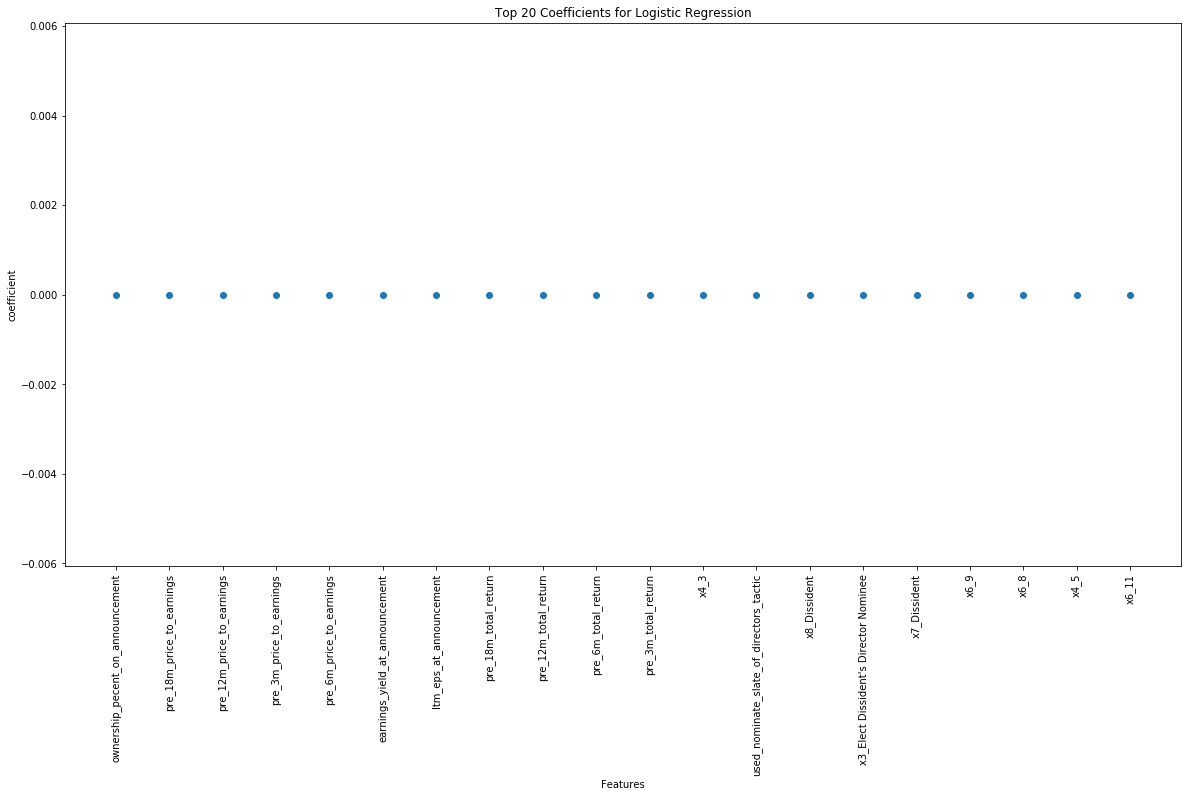

In [23]:
# Logistic regression with best parameter
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto', C = 1.000000000000005)
lg_l2.fit(x_train, y_train)

# Get top 20 important features
feature_importance_dict = dict(zip(combine, lg_l2.coef_[0]))
top_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]}
name = [item for item in top_20_important]
importance = [top_20_important[item] for item in top_20_important]

# Plot top 20 important features
_=plt.figure(figsize=(20,10))
_=plt.scatter(name,importance)
_=plt.xticks(rotation='vertical')
_=plt.title('Top 20 Coefficients for Logistic Regression')
_=plt.xlabel('Features')
_=plt.ylabel('coefficient')

## Complete case

In [24]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')

# grid search
param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
grid = GridSearchCV(lg_l2, param_grid, cv=2)
grid.fit(x_train_complete, y_train_complete)
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train_complete, y_train_complete),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test_complete, y_test_complete),5)))

The best parameter for Logistic is {'C': 2.0}
Training accuracy for Logistic Regression is 0.67763
Testing accuracy for Logistic Regression is 0.54568


In [25]:
# confusion_matrix with order: ['Missing', 'Dissident', 'Management']
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, grid) 
conf

array([[ 91,  85],
       [ 99, 130]])

In [26]:
pre_recall

,Precision,Recall
Management,0.478947,0.517045
Dissident,0.604651,0.567686


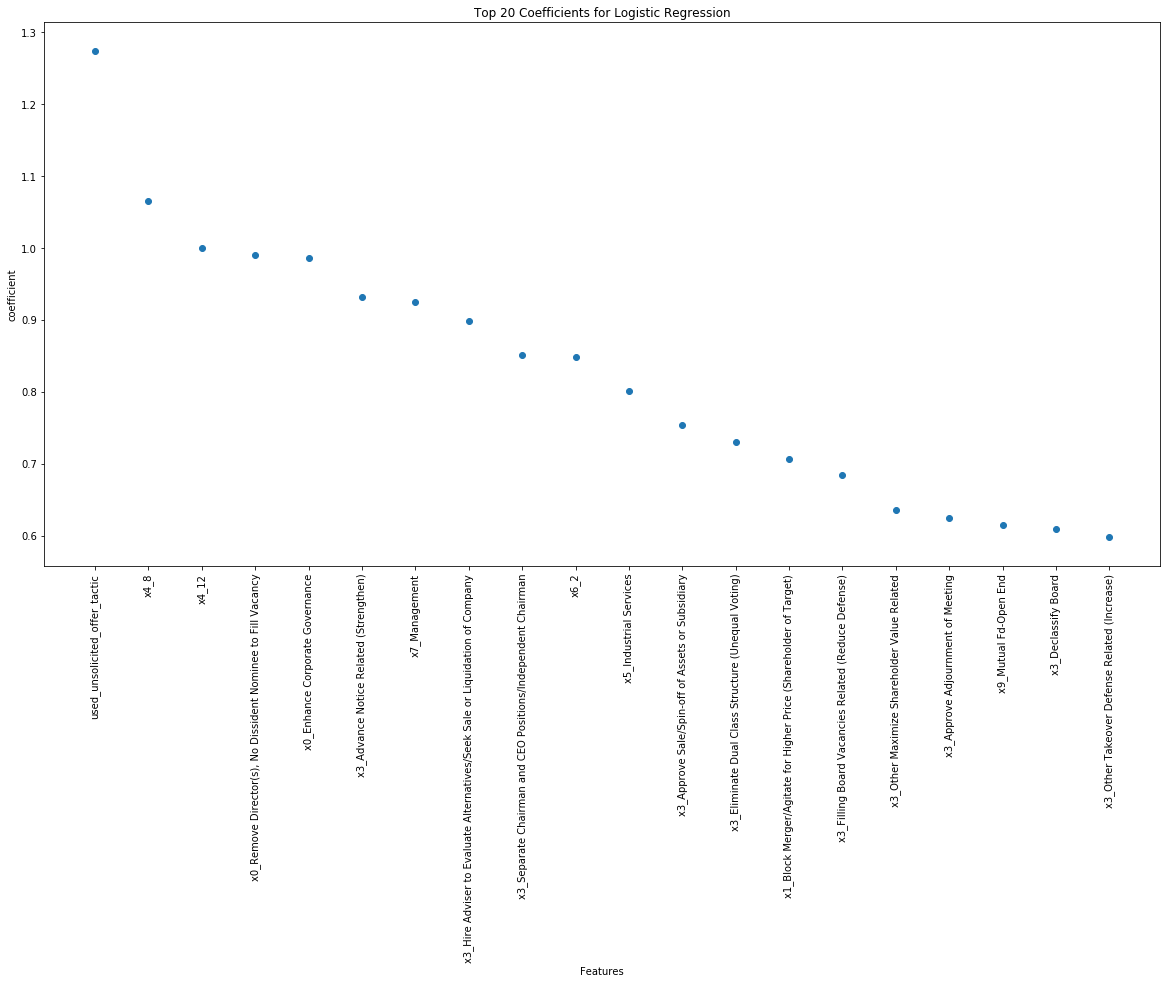

In [27]:
# Logistic regression with best parameter
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto', C = 2)
lg_l2.fit(x_train_complete, y_train_complete)

# Get top 20 important features
feature_importance_dict = dict(zip(combine2, lg_l2.coef_[0]))
top_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]}
name = [item for item in top_20_important]
importance = [top_20_important[item] for item in top_20_important]

# Plot top 20 important features
_=plt.figure(figsize=(20,10))
_=plt.scatter(name,importance)
_=plt.xticks(rotation='vertical')
_=plt.title('Top 20 Coefficients for Logistic Regression')
_=plt.xlabel('Features')
_=plt.ylabel('coefficient')

## Random Forest

In [28]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': np.linspace(10, 500, 5).astype('int'),
#               'randomforestclassifier__max_depth':np.linspace(10, 500, 5).astype('int'),
#               'randomforestclassifier__min_samples_split':np.linspace(10, 500, 5).astype('int'),
#               'randomforestclassifier__min_samples_leaf':np.linspace(10, 500, 5).astype('int'),
             }
grid = GridSearchCV(rf, param_grid, cv=5)
grid.fit(x_train, y_train)
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Random Forest is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing accuracy for Random Forest is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'n_estimators': 377}
Training accuracy for Random Forest is 0.99994
Testing accuracy for Random Forest is 0.90961


In [29]:
# confusion_matrix with order: ['Missing', 'Dissident', 'Management']
conf, pre_recall = produce_confusion_matrix(x_test, y_test, grid) 
conf

array([[1340,    6,    2],
       [   7,  131,   51],
       [   0,   91,  109]])

In [30]:
pre_recall

,Precision,Recall
Missing,0.994803,0.994065
Dissident,0.574561,0.693122
Management,0.672840,0.545000


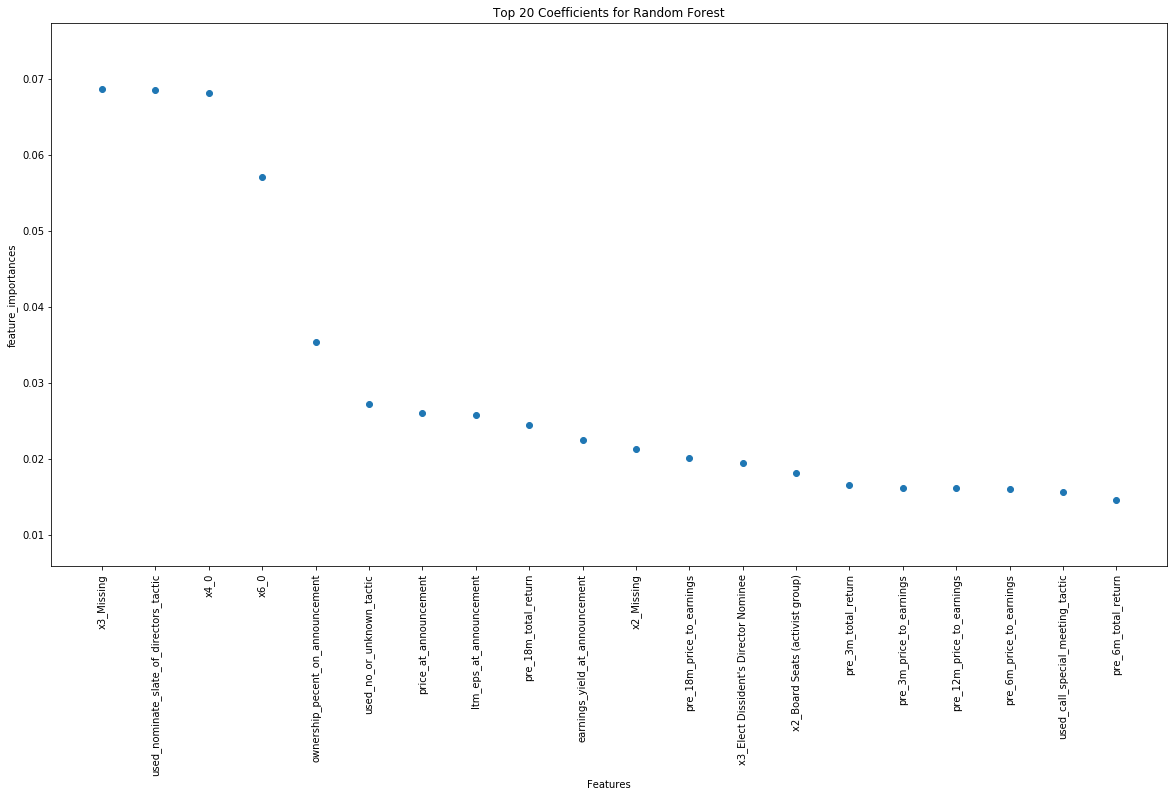

In [31]:
# Random Forest with best parameter
rf = RandomForestClassifier(n_estimators= 500)
rf.fit(x_train, y_train)

# Get top 20 important features
feature_importance_dict = dict(zip(combine, rf.feature_importances_))
top_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]}
name = [item for item in top_20_important]
importance = [top_20_important[item] for item in top_20_important]

# Plot top 20 important features
_=plt.figure(figsize=(20,10))
_=plt.scatter(name,importance)
_=plt.xticks(rotation='vertical')
_=plt.title('Top 20 Coefficients for Random Forest')
_=plt.xlabel('Features')
_=plt.ylabel('feature_importances')

## Xgboost

In [32]:
xgb = XGBClassifier()
param_grid = {
        'min_child_weight': [ 5],
#         'xgb__gamma': [0.5, 1, 1.5, 2, 5],
#         'xgb__subsample': [0.6, 0.8, 1.0],
#         'xgb__colsample_bytree': [0.6, 0.8, 1.0],
#         'xgb__max_depth': [3, 4, 5]
        }
# param_test1 = {
#  'xgb__max_depth':range(3,10,2),
#  'xgb__min_child_weight':range(1,6,2)
# }
grid = GridSearchCV(xgb, param_grid, cv=5)
grid.fit(x_train, y_train)
print("The best parameter for xgboost is {}".format(grid.best_params_))
print("Training accuracy for xgboost is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing accuracy for xgboost is {}".format(round(grid.score(x_test, y_test),5)))


The best parameter for xgboost is {'min_child_weight': 5}
Training accuracy for xgboost is 0.85634
Testing accuracy for xgboost is 0.90789


In [33]:
# confusion_matrix with order: ['Missing', 'Dissident', 'Management']
conf, pre_recall = produce_confusion_matrix(x_test, y_test, grid) 
conf

array([[1343,    5,    0],
       [   7,  125,   57],
       [   0,   91,  109]])

In [34]:
pre_recall

,Precision,Recall
Missing,0.994815,0.996291
Dissident,0.565611,0.661376
Management,0.656627,0.545000


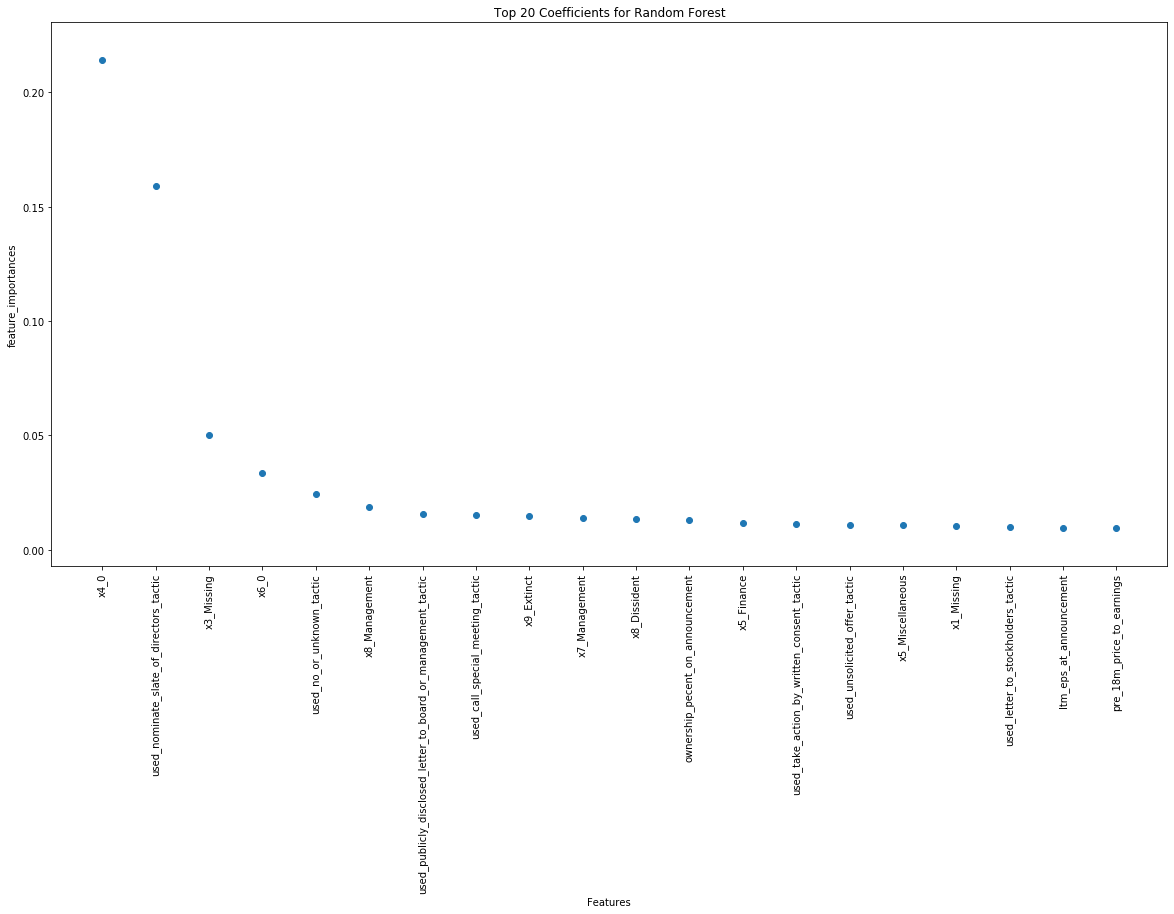

In [35]:
# XGBoost with best parameter
xgb = XGBClassifier(min_child_weight = 5)
xgb.fit(x_train, y_train)

# Get top 20 important features
feature_importance_dict = dict(zip(combine, xgb.feature_importances_))
top_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]}
name = [item for item in top_20_important]
importance = [top_20_important[item] for item in top_20_important]

# Plot top 20 important features
_=plt.figure(figsize=(20,10))
_=plt.scatter(name,importance)
_=plt.xticks(rotation='vertical')
_=plt.title('Top 20 Coefficients for Random Forest')
_=plt.xlabel('Features')
_=plt.ylabel('feature_importances')

## Nearest Centroid

In [36]:
nc = NearestCentroid()
param_grid = {'metric':['euclidean','manhattan']}
grid = GridSearchCV(nc, param_grid, cv=5)
grid.fit(x_train, y_train)
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'metric': 'manhattan'}
Training accuracy for Logistic Regression is 0.47969
Testing accuracy for Logistic Regression is 0.56995


In [37]:
# confusion_matrix with order: ['Missing', 'Dissident', 'Management']
conf, pre_recall = produce_confusion_matrix(x_test, y_test, grid) 
conf

array([[886, 159, 303],
       [ 94,  27,  68],
       [ 97,  26,  77]])

In [38]:
pre_recall

,Precision,Recall
Missing,0.822656,0.657270
Dissident,0.127358,0.142857
Management,0.171875,0.385000


## Support Vector Matchine

In [39]:
svc = svm.SVC(kernel='rbf')
svc.fit(x_train,y_train)
# confusion_matrix with order: ['Missing', 'Dissident', 'Management']
conf, pre_recall = produce_confusion_matrix(x_test, y_test, svc) 
conf

array([[1348,    0,    0],
       [ 186,    0,    3],
       [ 197,    0,    3]])

In [40]:
pre_recall

,Precision,Recall
Missing,0.778741,1.000
Dissident,NaN,0.000
Management,0.500000,0.015


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=1)
# clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
# clf3 = GaussianNB()
# lg_pipe = make_pipeline(preprocess, LogisticRegression(penalty = 'l1',multi_class = 'auto', C = 0.5000000000000075))
# lg_pipe2 = make_pipeline(preprocess, LogisticRegression(penalty = 'l2',multi_class = 'auto', C = 1.5555555555555578))
# rf_pipe = make_pipeline(preprocess, RandomForestClassifier(n_estimators= 132))
# xgb_pipe = Pipeline([('preprocess', preprocess),('xgb', XGBClassifier(min_child_weight=5))])
# nc_pipe = make_pipeline(preprocess, NearestCentroid(metric = 'manhattan'))

## Hard Vote

In [50]:
eclf1 = VotingClassifier(estimators=[('lg', lg_l1), 
                                     ('lg2', lg_l2), 
                                     ('rf', rf),
                                    ('xgb', xgb), 
                                    ('nc', nc)], 
                         voting='hard')
eclf1 = eclf1.fit(x_train, y_train)
y_pred1 = eclf1.predict(x_test)
print("Accuracy is %.2f%%" % ((np.sum(y_pred1 == np.array(y_test).flatten()) / len(y_pred1))*100))


Accuracy is 90.79%


In [51]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, eclf1) 
conf

array([[1340,    5,    3],
       [   5,  139,   45],
       [   0,  102,   98]])

In [52]:
pre_recall

,Precision,Recall
Missing,0.996283,0.994065
Dissident,0.565041,0.735450
Management,0.671233,0.490000


## Soft Vote

In [54]:
eclf2 = VotingClassifier(estimators=[('lg', lg_l1), 
                                     ('lg2', lg_l2), 
                                     ('rf', rf),
                                    ('xgb', xgb)], 
                         voting='soft')
eclf2 = eclf2.fit(x_train, y_train)
y_pred2 = eclf2.predict(x_test)
print("Accuracy is %.2f%%" % ((np.sum(y_pred2 == np.array(y_test).flatten()) / len(y_pred2))*100))

Accuracy is 91.08%


In [55]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, eclf2) 
conf

array([[1342,    5,    1],
       [   6,  133,   50],
       [   0,   93,  107]])

In [56]:
pre_recall

,Precision,Recall
Missing,0.995549,0.995549
Dissident,0.575758,0.703704
Management,0.677215,0.535000


## Weights Based Weights Soft Vote

In [58]:
compute_weights = lambda pipelines,x_train,y_train,x_test,y_test: [x.fit(x_train,y_train).score(x_test,y_test) for x in pipelines]
ensemble = [lg_l1,lg_l2,rf,xgb]
weights = compute_weights(ensemble,x_train,y_train,x_test,y_test)

eclf3 = VotingClassifier(estimators=[('lg', lg_l1), 
                                     ('lg2', lg_l2), 
                                     ('rf', rf),
                                    ('xgb', xgb)], 
                                     voting='soft', 
                                     weights=weights,
                                     flatten_transform=True)
eclf3 = eclf3.fit(x_train, y_train)
y_pred3 = eclf3.predict(x_test)
print("Accuracy is %.2f%%" % ((np.sum(y_pred3 == np.array(y_test).flatten()) / len(y_pred3))*100))

Accuracy is 91.02%


In [59]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, eclf3) 
conf

array([[1342,    5,    1],
       [   6,  133,   50],
       [   0,   94,  106]])

In [60]:
pre_recall

,Precision,Recall
Missing,0.995549,0.995549
Dissident,0.573276,0.703704
Management,0.675159,0.530000


In [ ]:
X_tf = X.copy()
Y_tf = Y.copy()
X_tf['ltm_eps_at_announcement'] = 1/ X_tf['ltm_eps_at_announcement']

pipeline_component = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = -9999))
pipeline_component_numeric = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = 'NA'),
                                          (OneHotEncoder(handle_unknown='ignore')))
preprocess = make_column_transformer((pipeline_component,~cate),
                                     (pipeline_component_numeric,cate))

le = preprocessing.LabelEncoder()

In [ ]:
X_tf = preprocess.fit_transform(X_tf).toarray()
Y_tf_map = le.fit(Y_tf).classes_
Y_tf = le.transform(Y_tf)
x_train, x_test, y_train, y_test = train_test_split(X_tf,Y_tf,test_size = 0.2)


## Try Neural Network

In [ ]:
import tensorflow as tf
class proxy_results_classifier(tf.keras.Model):
    
    def __init__(self,num_classes):
        super(proxy_results_classifier, self).__init__()
        self.d1 = tf.keras.layers.Dense(512)
        self.norm_1 = tf.keras.layers.BatchNormalization()
        
        self.d2 = tf.keras.layers.Dense(256)
        self.norm_2 = tf.keras.layers.BatchNormalization()
        
        self.d3 = tf.keras.layers.Dense(128)
        self.norm_3 = tf.keras.layers.BatchNormalization()
        
        self.d4 = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.relu = tf.nn.relu

    def call(self, x):
        x = self.d1(x)
        x = self.norm_1(x)
        x = self.relu(x)
        
        x = self.d2(x)
        x = self.norm_2(x)
        x = self.relu(x)
        
        x = self.d3(x)
        x = self.norm_3(x)
        x = self.relu(x)
        
        x = self.d4(x)
        
        return x

# Create an instance of the model
model = proxy_results_classifier(len(set(y_test)))

In [ ]:
y_test

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=30, batch_size=60)

In [ ]:
y_test

In [ ]:
scores = model.evaluate(x_test, y_test)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_object(x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [ ]:
batch = 240
x_train_0 = x_train[y_train == 0]
x_train_1 = x_train[y_train == 1]
x_train_2 = x_train[y_train == 2]
x_train_3 = x_train[y_train == 3]
x_train_4 = x_train[y_train == 4]
x_train_5 = x_train[y_train == 5]

In [ ]:
sample_indinces = lambda sample_num
sample = lambda x_list,x_sample_indices: np.concatenate([x_list[i][x_sample_indices[i]] for i in range(len(x_list))],axis = 0)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    for x, y in train_ds:
    for i in range(10):
        x_t=
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                    train_loss.result(),
                    train_accuracy.result()*100,
                    test_loss.result(),
                    test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()